In [1]:
import pandas as pd
import numpy as np
import sys,os
#from pyLimma import model_matrix

from random import sample,seed
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Extract read counts and annotations of skin samples

### variables
(descriptions from GTEx)
- sample:
    * SMATSSCR - Autolysis Score (assigned by a pathologist during a visual inspection of the histology image): 0-3: None, Mild, Moderate, and Severe
    * SMTSISCH - Total Ischemic time for a sample:  the time from death or withdrawal of life-support until the time the sample is placed in a fixative solution or frozen. 
    * SMTSPAX - Time a sample spent in the PAXgene fixative
- subject:
    * SEX (1-male ,2 - female; -> is_female 0/1 )
    * DTHHRDY - Hardy scale death: categorizes how long a subject was dying prior to the collection of the sample:

        * 0 - On a ventilator immediately before death
        * 1 - Deaths due to accident, blunt force trauma or suicide
        * 2 - Sudden unexpected deaths of people who had been reasonably healthy (e.g., from heart attack)
        * 3 - Intermediate death (between 2 and 4)
        * 4 - Death after a long illness (e.g., cancer)



For each patient no more then one sun-exposed and one non-sun-exposed skin samples were kept.

In [2]:
anno = pd.read_csv("GTEx_skin/downloads/GTEx_Analysis_v8_Annotations_SampleAttributesDS.tsv",sep="\t",index_col=0)
#anno.loc[:,["SMTS","SMTSD"]].drop_duplicates().sort_values(by ="SMTS")
anno = anno.loc[anno["SMTSD"].isin(["Skin - Sun Exposed (Lower leg)","sun_exposed","Skin - Not Sun Exposed (Suprapubic)","not_sun_exposed"]),:]
anno = anno.loc[anno["SMGEBTCHT"]=="TruSeq.v1",:]
anno = anno.loc[:,["SMTSD","SMATSSCR","SMTSISCH","SMTSPAX"]] 
anno["SUBJID"] = anno.index.values
anno["SUBJID"] = anno["SUBJID"].apply(lambda x : "-".join(x.split("-")[:2]))
anno["sun_exposed"] = 0
anno["not_sun_exposed"] = 0

anno.loc[anno["SMTSD"]=="Skin - Sun Exposed (Lower leg)","sun_exposed"] =1
anno.loc[anno["SMTSD"]=="Skin - Not Sun Exposed (Suprapubic)","not_sun_exposed"] =1


anno2 = pd.read_csv("GTEx_skin/downloads/GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.tsv",sep = "\t",index_col = 0)
anno = anno.join(anno2, on="SUBJID")
anno["sex"] = 0
anno.loc[anno["SEX"]==2,"sex"]=1 # 1 for females
# set average age for age group
anno["age"] = anno["AGE"].apply(lambda x: sum(map(int,x.split("-")))*1.0/2)


rename_dict = {"SMATSSCR":"autolisys_score","SMTSISCH":"ischemic_time","SMTSPAX":"pax_time",
              "SUBJID":"subject_id","AGE":"age_group","DTHHRDY":"hardy_scale_death"}
anno.rename(rename_dict, axis="columns",inplace=True)
anno = anno.loc[:,["sun_exposed","not_sun_exposed","autolisys_score","ischemic_time","pax_time","age_group","age","sex","hardy_scale_death","subject_id"]]
anno.drop_duplicates(subset = ["sun_exposed","not_sun_exposed","subject_id"],inplace = True)
print("total samples:",anno.shape[0])
print(anno.loc[:,["sun_exposed","not_sun_exposed"]].sum(axis=0))
anno


total samples: 1375
sun_exposed        743
not_sun_exposed    632
dtype: int64


,sun_exposed,not_sun_exposed,autolisys_score,ischemic_time,pax_time,age_group,age,sex,hardy_scale_death,subject_id
SAMPID,,,,,,,,,,
GTEX-1117F-2926-SM-5GZYI,0,1,0.0,1341.0,1006.0,60-69,64.5,1,4.0,GTEX-1117F
GTEX-111CU-1126-SM-5EGIM,0,1,1.0,86.0,623.0,50-59,54.5,0,0.0,GTEX-111CU
GTEX-111CU-1926-SM-5GZYZ,1,0,1.0,141.0,568.0,50-59,54.5,0,0.0,GTEX-111CU
GTEX-111FC-0126-SM-5N9DL,1,0,1.0,1036.0,870.0,60-69,64.5,0,1.0,GTEX-111FC
GTEX-111FC-2526-SM-5GZXU,0,1,1.0,1135.0,781.0,60-69,64.5,0,1.0,GTEX-111FC
GTEX-111VG-1626-SM-5EGIO,0,1,1.0,1046.0,911.0,60-69,64.5,0,3.0,GTEX-111VG
GTEX-111VG-2426-SM-5GZXD,1,0,1.0,1084.0,873.0,60-69,64.5,0,3.0,GTEX-111VG
GTEX-111YS-1526-SM-5GZYW,0,1,0.0,163.0,726.0,60-69,64.5,0,0.0,GTEX-111YS
GTEX-1122O-1026-SM-9WYSF,0,1,0.0,94.0,909.0,60-69,64.5,1,0.0,GTEX-1122O


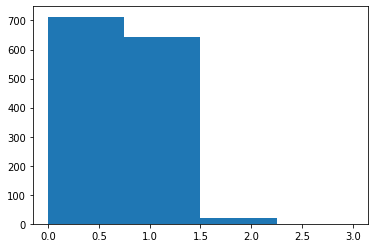

In [3]:
tmp = plt.hist(anno["autolisys_score"].values,bins=4,range=(0,3))

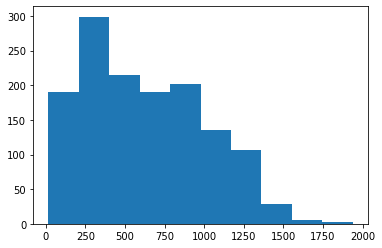

In [4]:
tmp = plt.hist(anno["ischemic_time"].values)

/home/olya/anaconda3/envs/py3.7/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/olya/anaconda3/envs/py3.7/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


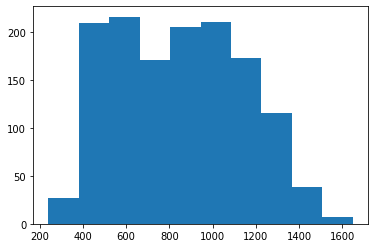

In [5]:
tmp = plt.hist(anno["pax_time"].values)

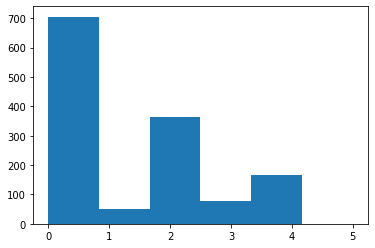

In [6]:
tmp = plt.hist(anno["hardy_scale_death"],bins=6,range=(0,5))

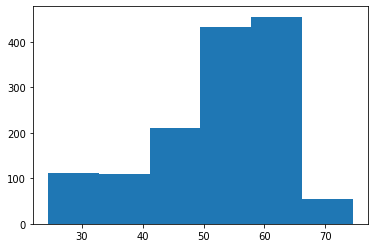

In [7]:
tmp = plt.hist(anno["age"].values, bins=6,range=(24.5,74.5))

In [8]:
anno.loc[:,["sun_exposed","autolisys_score","ischemic_time","pax_time","age","sex","hardy_scale_death"]].corr()

,sun_exposed,autolisys_score,ischemic_time,pax_time,age,sex,hardy_scale_death
sun_exposed,1.000000,0.012353,-0.003697,0.038015,-0.011020,0.008561,0.002233
autolisys_score,0.012353,1.000000,0.180615,0.035876,0.082163,0.008229,0.122099
ischemic_time,-0.003697,0.180615,1.000000,0.137926,0.251581,-0.103242,0.599092
pax_time,0.038015,0.035876,0.137926,1.000000,0.025812,-0.034452,0.085778
age,-0.011020,0.082163,0.251581,0.025812,1.000000,-0.010702,0.396145
sex,0.008561,0.008229,-0.103242,-0.034452,-0.010702,1.000000,-0.053331
hardy_scale_death,0.002233,0.122099,0.599092,0.085778,0.396145,-0.053331,1.000000


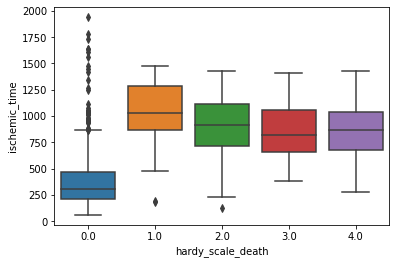

In [9]:
sns.boxplot(data = anno.loc[:,["hardy_scale_death","ischemic_time"]], x = "hardy_scale_death", y= "ischemic_time")

In [10]:
anno.index.values

array(['GTEX-1117F-2926-SM-5GZYI', 'GTEX-111CU-1126-SM-5EGIM',
       'GTEX-111CU-1926-SM-5GZYZ', ..., 'GTEX-ZZ64-1726-SM-5GZYB',
       'GTEX-ZZPT-0226-SM-5E43X', 'GTEX-ZZPU-0826-SM-5GZX5'], dtype=object)

In [11]:
# exclude absent sample names
not_found_samples = ['GTEX-S4UY-0126-SM-3K2BB', 'GTEX-12WS9-0126-SM-5EGL7', 'GTEX-1IDJC-1726-SM-CMKG3', 'GTEX-XOTO-0126-SM-4B66N', 'GTEX-15DCZ-0626-SM-6AJ9I', 'GTEX-ZVT4-0126-SM-51MS1', 'GTEX-UPK5-0726-SM-4IHL7', 'GTEX-PLZ6-1426-SM-2S1OQ', 'GTEX-12WSN-1426-SM-5GCO6', 'GTEX-1AX8Y-1126-SM-731AG', 'GTEX-ZVZQ-0326-SM-59HLL', 'GTEX-YF7O-2326-101833-SM-5CVN9', 'GTEX-PSDG-0226-SM-2I5FR', 'GTEX-PLZ4-0126-SM-2S1OG', 'GTEX-ZAB5-2626-SM-5KM3Y', 'GTEX-TMKS-0126-SM-3DB7S', 'GTEX-RVPU-2226-SM-2XCAQ', 'GTEX-1B932-0126-SM-7PC2M', 'GTEX-146FR-1326-SM-5SIAJ', 'GTEX-13O3O-0126-SM-5KM4E', 'GTEX-UPIC-1626-SM-4IHKT', 'GTEX-15RIF-1926-SM-7KUDW', 'GTEX-19HZE-2926-SM-718BQ', 'GTEX-13PVQ-0126-SM-5SIB4', 'GTEX-15CHS-0626-SM-6AJA3', 'GTEX-ZQG8-1626-SM-5HL6H', 'GTEX-15TU5-0226-SM-6PALR', 'GTEX-YFC4-0126-101855-SM-5CVLZ', 'GTEX-ZT9W-2426-SM-57WFJ', 'GTEX-1HBPH-2026-SM-CMKGL', 'GTEX-YEC3-1326-SM-4WWEL', 'GTEX-PW2O-1526-SM-2I5FT', 'GTEX-ZYWO-2226-SM-5GZXR', 'GTEX-19HZE-0126-SM-73KX7', 'GTEX-11ILO-0626-SM-5A5LO', 'GTEX-ZV7C-0926-SM-59HL1', 'GTEX-XUJ4-1826-SM-4BOOU', 'GTEX-111CU-1926-SM-5GZYZ', 'GTEX-1AX8Y-2026-SM-73KUA', 'GTEX-Q2AG-0126-SM-2HMLB', 'GTEX-13FH7-2026-SM-5IJCR', 'GTEX-1B98T-0826-SM-7DHME', 'GTEX-R55F-0126-SM-48FCK', 'GTEX-1EH9U-0126-SM-7SB87', 'GTEX-1A8G6-0426-SM-72D6Q', 'GTEX-11ILO-0126-SM-5A5LN', 'GTEX-XUJ4-2426-SM-4BOO3', 'GTEX-13OW5-0126-SM-5MR3A', 'GTEX-SIU7-1726-SM-2XCDZ', 'GTEX-XOTO-0726-SM-4B659', 'GTEX-11TUW-2726-SM-5EQLC', 'GTEX-ZQG8-1926-SM-4YCEO', 'GTEX-16NFA-1526-SM-7KULS', 'GTEX-1OKEX-2026-SM-E8VNL', 'GTEX-12WSG-2826-SM-5FQUS', 'GTEX-PWN1-0126-SM-2I3FK', 'GTEX-N7MS-0225-SM-4E3HO', 'GTEX-131XF-2126-SM-5DUWS', 'GTEX-OIZG-0726-SM-2I5GS', 'GTEX-17GQL-0926-SM-731E7', 'GTEX-12WSN-2326-SM-5DUVG', 'GTEX-RNOR-0126-SM-2TF57', 'GTEX-1A8G7-0126-SM-7DUGH', 'GTEX-P44G-0226-SM-2I3F3', 'GTEX-P4QR-0326-SM-2S1NU', 'GTEX-YEC3-1826-101807-SM-EYYVR', 'GTEX-1RDX4-2926-SM-E8VOF', 'GTEX-ZLV1-1526-SM-4WWBC', 'GTEX-YEC4-2126-101817-SM-EYYVS', 'GTEX-16NFA-2326-SM-7KUE5', 'GTEX-15SHV-2426-SM-6PAMF', 'GTEX-QEG5-0226-SM-2I5GI', 'GTEX-1F75W-0126-SM-9KNVT', 'GTEX-ZP4G-2426-SM-57WEY', 'GTEX-OXRK-0226-SM-2YUN1', 'GTEX-11EQ8-0126-SM-5EQ54', 'GTEX-1RQED-0126-SM-E9U6M', 'GTEX-S341-1726-SM-3K2AK', 'GTEX-12ZZW-0126-SM-5DUVB', 'GTEX-12WSB-0126-SM-59HJN', 'GTEX-13NYC-0326-SM-5K7WP', 'GTEX-131XE-1626-SM-5K7VO', 'GTEX-12WS9-0326-SM-59HJV', 'GTEX-PWCY-1826-SM-2S1OK', 'GTEX-S7SF-1626-SM-3K2AY', 'GTEX-13111-1826-SM-5GCP1', 'GTEX-1QP6S-0326-SM-DTXF7', 'GTEX-11P82-1426-SM-5BC5L', 'GTEX-1PBJI-1426-SM-EYYXG', 'GTEX-15UKP-1526-SM-6PAL9', 'GTEX-13OVI-2726-SM-5KM56', 'GTEX-12WSB-2926-SM-59HKL', 'GTEX-13113-1926-SM-5LZWG', 'GTEX-WFG7-2026-SM-3GIL7', 'GTEX-1LSNL-0226-SM-EVYCG', 'GTEX-ZPIC-1726-SM-57WF2', 'GTEX-S3XE-1726-SM-3K2AM', 'GTEX-15TU5-2426-SM-7KUDU']
samples = set(anno.index.values).difference(set(not_found_samples))
len(samples)

1277

In [36]:
exprs = pd.read_csv("GTEx_skin/downloads/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.tsv.gz",
                    sep="\t", compression='gzip', usecols = ["Description"]+list(samples))
print("Expressions (genes x samples):",exprs.shape)
exprs.set_index("Description",drop=True,inplace=True)
exprs = exprs.loc[sorted(exprs.index.values),sorted(exprs.columns.values)]

# sum transcripts to gene level
dfs = {}
for gene in set(exprs.index):
    df = exprs.loc[gene,:]
    if len(df.shape) ==2:
        dfs[gene] = df.sum(axis=0)
    else:
        dfs[gene] = df
exprs = pd.DataFrame.from_dict(dfs).T


exprs.to_csv("GTEx_skin/Skin_samples.counts.tsv",sep="\t")

exprs

KeyboardInterrupt: 

In [12]:
exprs = pd.read_csv("GTEx_skin/Skin_samples.counts.tsv",sep="\t",index_col=0)

In [13]:
exprs.loc["uc_338",:]#.sum(axis=0)

GTEX-1117F-2926-SM-5GZYI     416
GTEX-111CU-1126-SM-5EGIM    1536
GTEX-111FC-0126-SM-5N9DL     768
GTEX-111FC-2526-SM-5GZXU     640
GTEX-111VG-1626-SM-5EGIO     832
                            ... 
GTEX-ZYY3-2926-SM-5GIEB      576
GTEX-ZZ64-1026-SM-5GZXG     1056
GTEX-ZZ64-1726-SM-5GZYB     1536
GTEX-ZZPT-0226-SM-5E43X     1088
GTEX-ZZPU-0826-SM-5GZX5      864
Name: uc_338, Length: 1277, dtype: int64

In [16]:
anno.loc[exprs.columns.values,:].to_csv("GTEx_skin/Skin_samples.annotation.tsv",sep="\t")

In [14]:
anno = pd.read_csv("GTEx_skin/Skin_samples.annotation.tsv",sep="\t",index_col=0)
anno = anno.loc[:,["sun_exposed","not_sun_exposed","sex","ischemic_time"]]#+dscales[:-1]]
anno.sort_values("ischemic_time",inplace=True)
anno["ischemic_time"] = anno["ischemic_time"].apply(float)
anno["ischemic_time_group"] =  pd.qcut(anno["ischemic_time"],3, labels=range(0,3)) 
anno

,sun_exposed,not_sun_exposed,sex,ischemic_time,ischemic_time_group
SAMPID,,,,,
GTEX-Z93T-0126-SM-5HL5N,1,0,0,17.0,0
GTEX-XUYS-0126-SM-47JWZ,1,0,0,27.0,0
GTEX-SSA3-0126-SM-32QPU,1,0,0,40.0,0
GTEX-X638-0126-SM-47JZ8,1,0,1,42.0,0
GTEX-TMZS-0126-SM-3DB9Q,1,0,0,49.0,0
GTEX-1399S-0126-SM-5IJCF,0,1,1,60.0,0
GTEX-ZVT2-0126-SM-5GIDQ,0,1,1,85.0,0
GTEX-14PK6-0226-SM-62LF5,0,1,1,85.0,0
GTEX-132AR-0326-SM-5KM2C,0,1,1,85.0,0


In [15]:
# keep only annotated 
annotated = set(anno.index.values).intersection(exprs.columns.values)
print("Samples wiht expression and annotation:",len(annotated))
exprs = exprs.loc[:,sorted(annotated)]
anno = anno.loc[sorted(annotated),:]
print("%  sun_exposed :", round(anno["sun_exposed"].sum()/len(annotated),2))
print("% Female:", round(anno["sex"].sum()/len(annotated),2))
print("mean ischemic time:",round(anno["ischemic_time"].mean(axis=0),1))
#anno.to_csv("TCGA-BRCA/TCGA.annotation_v3.tsv", sep = "\t")

Samples wiht expression and annotation: 1277
%  sun_exposed : 0.53
% Female: 0.32
mean ischemic time: 633.6


In [32]:
1277 - anno["sun_exposed"].sum()

600

# Make splits 

In [16]:
root_dir = "GTEx_skin/balanced/"

### No imbalance 

In [29]:
anno2 = anno.copy()
anno2["split"] = "Split_3"
N = anno.shape[0]*1.0*1.0
N_se = anno.loc[anno["sun_exposed"]==1,:].shape[0]*1.0
N_fem = anno.loc[anno["sex"]==1,:].shape[0]*1.0
print(N,N_se,N_fem)
random_state = 42
seed(random_state)
n_splits = 3
sizes = [1,1,1]#sizes = [1,1,1,1,1]
se_freqs = [0.53,0.53,0.53]#se_freqs = [0.53,0.53,0.53,0.53,0.52]
fem_freqs = [0.32,0.32,0.32]#fem_freqs = [0.32,0.32,0.32,0.32,0.32]

Sizes = []
n_se = []
n_fem = []
for i in range(0,n_splits-1):
    s  = int(N*sizes[i]/sum(sizes))
    Sizes.append(s)
    n_se.append(int(s*se_freqs[i]))
    n_fem.append(int(s * fem_freqs[i]))

Sizes.append(int(N-sum(Sizes)))
n_se.append(int(N_se-sum(n_se)))
n_fem.append(int(N_fem-sum(n_fem)))
print(Sizes, sum(Sizes))
print(n_se, sum(n_se))
print(n_fem, sum(n_fem))


splits = {}
se = set(anno.loc[anno["sun_exposed"]==1,:].index.values)
#fem = set(anno.loc[anno["is_female"]==1,:].index.values)
other = set(anno.index.values).difference(se)#.difference(fem)
for i in range(0,n_splits-1):
    b = set(sample(se,n_se[i]))  
    se =  se.difference(b)
    #fe = set(sample(fem,n_fem[i]))
    #fem = fem.difference(fe)
    o = set(sample(other,Sizes[i]-n_se[i])) #-n_fem[i]
    other = other.difference(o)
    sele_samples = b |o # | fe
    anno2.loc[sele_samples,"split"] = "Split_"+str(i+1)
    anno2["Split_"+str(i+1)] = 0
    anno2.loc[sele_samples,"Split_"+str(i+1)]  =1
stats = anno2[["split","sun_exposed","sex","ischemic_time"]].groupby("split").agg("mean")
stats["n_samples"] = anno2[["split","sex"]].groupby("split").agg("count")
stats  

1277.0 677.0 412.0
[425, 425, 427] 1277
[225, 225, 227] 677
[136, 136, 140] 412


,sun_exposed,sex,ischemic_time,n_samples
split,,,,
Split_1,0.529412,0.324706,629.143529,425
Split_2,0.529412,0.341176,636.035294,425
Split_3,0.531616,0.302108,635.592506,427


In [30]:
root_dir = "GTEx_skin/"
outdir = root_dir +"/"+"balanced/"
if not os.path.exists(outdir):
    os.makedirs(outdir)
splits = []
for i in range(n_splits):
    s = "Split_"+str(i+1)
    splits.append(s)
    df = anno2.loc[anno2["split"]==s,["sun_exposed","not_sun_exposed","sex","ischemic_time"]]
    samples = sorted(df.index.values)
    df.loc[samples,:].to_csv(outdir+"/"+s+".design.tsv",sep = "\t")
    exprs.loc[:,samples ].to_csv(outdir+"/"+s+".counts.tsv",sep = "\t")

df = anno2.loc[:,["sun_exposed","not_sun_exposed","sex","ischemic_time"]+splits[:-1]]
samples = sorted(df.index.values)
df.loc[samples,:].to_csv(outdir+"/"+"All.design.tsv",sep = "\t")
exprs.loc[:,samples ].to_csv(outdir+"/"+"All.counts.tsv",sep = "\t")
print(df.shape, exprs.shape)
df.head(3)

(1277, 6) (54592, 1277)


,sun_exposed,not_sun_exposed,sex,ischemic_time,Split_1,Split_2
SAMPID,,,,,,
GTEX-1117F-2926-SM-5GZYI,0,1,1,1341.0,0,1
GTEX-111CU-1126-SM-5EGIM,0,1,0,86.0,1,0
GTEX-111FC-0126-SM-5N9DL,1,0,0,1036.0,1,0


## Mild imbalance 
*  cohort sizes, % of sun-exposed samples, ishemic time
* sex is a covariate



In [100]:
anno2 = anno.copy()
anno2["split"] = "Split_3"
N = anno.shape[0]*1.0*1.0
N_se = anno.loc[anno["sun_exposed"]==1,:].shape[0]*1.0
N_fem = anno.loc[anno["sex"]==1,:].shape[0]*1.0  # is female
print(N,N_se,N_fem)
random_state = 0
seed(random_state)
n_splits = 3
sizes = [1,2,4] #sizes = [1,1,2,2,4]
se_freqs = [0.4,0.65,0.5] #se_freqs = [0.4,0.65,0.4,0.5,0.5]
fem_freqs = [0.25,0.35,0.30]#fem_freqs = [0.32,0.32,0.32,0.32,0.32]

Sizes = []
n_se = []
n_fem = []
for i in range(0,n_splits-1):
    s  = int(N*sizes[i]/sum(sizes))
    Sizes.append(s)
    n_se.append(int(s*se_freqs[i]))
    #n_fem.append(int(s * fem_freqs[i]))

Sizes.append(int(N-sum(Sizes)))
n_se.append(int(N_se-sum(n_se)))
n_fem.append(int(N_fem-sum(n_fem)))
print(Sizes, sum(Sizes))
print(n_se, sum(n_se))
#print(n_fem, sum(n_fem))


splits = {}
se = set(anno.loc[anno["sun_exposed"]==1,:].index.values)
#fem = set(anno.loc[anno["is_female"]==1,:].index.values)
other = set(anno.index.values).difference(se)#.difference(fem)
for i in range(0,n_splits-1):
    b = set(sample(se.intersection(set( set(anno.loc[anno["ischemic_time_group"]==i,:].index.values))),int(n_se[i]*4/5))) |  set(sample(se.intersection(set( set(anno.loc[anno["ischemic_time_group"]!=i,:].index.values))),int(n_se[i]*1/5)))  
    se =  se.difference(b)
    #fe = set(sample(fem,n_fem[i]))
    #fem = fem.difference(fe)
    o = set(sample(other,Sizes[i]-n_se[i])) #-n_fem[i]
    other = other.difference(o)
    sele_samples = b |o # | fe
    anno2.loc[sele_samples,"split"] = "Split_"+str(i+1)
    anno2["Split_"+str(i+1)] = 0
    anno2.loc[sele_samples,"Split_"+str(i+1)]  =1
stats = anno2[["split","sun_exposed","sex","ischemic_time"]].groupby("split").agg("mean")
stats["n_samples"] = anno2[["split","sex"]].groupby("split").agg("count")
stats   

1277.0 677.0 412.0
[182, 364, 731] 1277
[72, 236, 369] 677


,sun_exposed,sex,ischemic_time,n_samples
split,,,,
Split_1,0.392265,0.348066,490.077348,181
Split_2,0.647383,0.325069,619.782369,363
Split_3,0.506139,0.315143,675.871760,733


In [93]:
root_dir = "GTEx_skin/"
outdir = root_dir +"/"+"mild_imbalance/"
if not os.path.exists(outdir):
    os.makedirs(outdir)
splits = []
for i in range(n_splits):
    s = "Split_"+str(i+1)
    splits.append(s)
    df = anno2.loc[anno2["split"]==s,["sun_exposed","not_sun_exposed","sex","ischemic_time"]]
    samples = sorted(df.index.values)
    df.loc[samples,:].to_csv(outdir+"/"+s+".design.tsv",sep = "\t")
    exprs.loc[:,samples ].to_csv(outdir+"/"+s+".counts.tsv",sep = "\t")

df = anno2.loc[:,["sun_exposed","not_sun_exposed","sex","ischemic_time"]+splits[:-1]]
samples = sorted(df.index.values)
df.loc[samples,:].to_csv(outdir+"/"+"All.design.tsv",sep = "\t")
exprs.loc[:,samples ].to_csv(outdir+"/"+"All.counts.tsv",sep = "\t")
print(df.shape, exprs.shape)
df.head(3)

(1277, 6) (54592, 1277)


,sun_exposed,not_sun_exposed,sex,ischemic_time,Split_1,Split_2
SAMPID,,,,,,
GTEX-Z93T-0126-SM-5HL5N,1,0,0,17.0,1,0
GTEX-XUYS-0126-SM-47JWZ,1,0,0,27.0,1,0
GTEX-SSA3-0126-SM-32QPU,1,0,0,40.0,0,1


## Strong Imbalance 

In [117]:
anno2 = anno.copy()
anno2["split"] = "Split_3"
N = anno.shape[0]*1.0*1.0
N_se = anno.loc[anno["sun_exposed"]==1,:].shape[0]*1.0
N_fem = anno.loc[anno["sex"]==1,:].shape[0]*1.0
print(N,N_se,N_fem)
random_state = 1
seed(random_state)
n_splits = 3
sizes = [1,3,9]
se_freqs = [0.81,0.40,0.50]
fem_freqs = [0.32,0.32,0.32]

Sizes = []
n_se = []
n_fem = []
for i in range(0,n_splits-1):
    s  = int(N*sizes[i]/sum(sizes))
    Sizes.append(s)
    n_se.append(int(s*se_freqs[i]))
    #n_fem.append(int(s * fem_freqs[i]))

Sizes.append(int(N-sum(Sizes)))
n_se.append(int(N_se-sum(n_se)))
n_fem.append(int(N_fem-sum(n_fem)))
print(Sizes, sum(Sizes))
print(n_se, sum(n_se))
print(n_fem, sum(n_fem))


splits = {}
se = set(anno.loc[anno["sun_exposed"]==1,:].index.values)
#fem = set(anno.loc[anno["is_female"]==1,:].index.values)
other = set(anno.index.values).difference(se)#.difference(fem)
for i in range(0,n_splits-1):
    b = set(sample(se.intersection(set( set(anno.loc[anno["ischemic_time_group"]==i,:].index.values))),int(n_se[i]*9/10))) |  set(sample(se.intersection(set( set(anno.loc[anno["ischemic_time_group"]!=i,:].index.values))),int(n_se[i]*1/10)))  
    se =  se.difference(b)
    #fe = set(sample(fem,n_fem[i]))
    #fem = fem.difference(fe)
    o = set(sample(other,Sizes[i]-n_se[i])) #-n_fem[i]
    other = other.difference(o)
    sele_samples = b |o # | fe
    anno2.loc[sele_samples,"split"] = "Split_"+str(i+1)
    anno2["Split_"+str(i+1)] = 0
    anno2.loc[sele_samples,"Split_"+str(i+1)]  =1
stats = anno2[["split","sun_exposed","sex","ischemic_time"]].groupby("split").agg("mean")
stats["ischemic_time_median"] =  anno2[["split","ischemic_time"]].groupby("split").agg("median")
stats["n_samples"] = anno2[["split","sex"]].groupby("split").agg("count")
stats   

1277.0 677.0 412.0
[98, 294, 885] 1277
[79, 117, 481] 677
[412] 412


,sun_exposed,sex,ischemic_time,ischemic_time_median,n_samples
split,,,,,
Split_1,0.804124,0.298969,346.804124,268.0,97
Split_2,0.395904,0.303754,645.986348,628.0,293
Split_3,0.544532,0.331454,660.862458,618.0,887


In [95]:
root_dir = "GTEx_skin/"
outdir = root_dir +"/"+"strong_imbalance/"
if not os.path.exists(outdir):
    os.makedirs(outdir)
splits = []
for i in range(n_splits):
    s = "Split_"+str(i+1)
    splits.append(s)
    df = anno2.loc[anno2["split"]==s,["sun_exposed","not_sun_exposed","sex","ischemic_time"]]
    samples = sorted(df.index.values)
    df.loc[samples,:].to_csv(outdir+"/"+s+".design.tsv",sep = "\t")
    exprs.loc[:,samples ].to_csv(outdir+"/"+s+".counts.tsv",sep = "\t")

df = anno2.loc[:,["sun_exposed","not_sun_exposed","sex","ischemic_time"]+splits[:-1]]
samples = sorted(df.index.values)
df.loc[samples,:].to_csv(outdir+"/"+"All.design.tsv",sep = "\t")
exprs.loc[:,samples ].to_csv(outdir+"/"+"All.counts.tsv",sep = "\t")
print(df.shape, exprs.shape)
df.head(3)

(1277, 6) (54592, 1277)


,sun_exposed,not_sun_exposed,sex,ischemic_time,Split_1,Split_2
SAMPID,,,,,,
GTEX-Z93T-0126-SM-5HL5N,1,0,0,17.0,1,0
GTEX-XUYS-0126-SM-47JWZ,1,0,0,27.0,1,0
GTEX-SSA3-0126-SM-32QPU,1,0,0,40.0,0,0
